<div style="text-align: center">
    <h1 style="font-size: 42px;"><strong>EEG-based Binary Classification of Emotional Arousal: </strong></h1>
</div>
<div style="text-align: center">
    <h3 h1 style="font-size: 30px;"><strong>Exploratory Analysis and Machine Learning on <a href='https://www.eecs.qmul.ac.uk/mmv/datasets/deap/'>DEAP Dataset</a></strong></h3>
</div>

<hr>

# **Abstract**

**Background:**  
Electroencephalography (EEG) provides a non-invasive window into brain activity and is increasingly explored in affective computing. Emotional arousal — a key dimension of emotional experience — can potentially be inferred from EEG features, though its neural signatures remain subtle and difficult to extract.

**Aims:**  
This study evaluates the feasibility of classifying binary emotional arousal (high vs. low) based on EEG recordings from the [DEAP dataset](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html). It was aimed to assess how well bandpower features from multiple frequency bands and scalp locations can distinguish arousal levels using both neural and classical machine learning classifiers.

**Methods:**  
EEG signals from 32 participants, each exposed to 40 music video trials (60 seconds each), were segmented into overlapping windows of 5 seconds with a 2.5-second step (50% overlap). For each window, absolute and relative bandpower was computed across four frequency bands (theta, alpha, beta, gamma) from 32 EEG channels, yielding 256 features per window. The resulting dataset contained 24,576 labeled windows (training + test). Feature selection was performed using random forest importance scores, and the top 50 features were used to train a neural network, along with logistic regression, random forest, SVM, and XGBoost classifiers. Performance was evaluated using accuracy and ROC AUC metrics.

**Results:**  
All models achieved similar performance, with test accuracy ranging from 0.59 to 0.63 and ROC AUC fixed at 0.64. The best accuracy was reached by the SVM classifier (63%). Neural networks, random forest, and XGBoost showed comparable but not superior performance.

**Conclusions:**  
The results suggest that EEG bandpower features carry only limited and hard-to-extract information about arousal, leading to modest model performance across classifiers. These findings highlight both the potential and limitations of EEG-based emotion recognition and suggest the need for more sophisticated feature engineering or multimodal data to improve performance in affective computing tasks.


# **Table of contents**

1. [Project overview](#1.-project-overview)  
2. [Required libraries](#2.-required-libraries)  
3. [Loading and understanding the EEG dataset](#3.-loading-and-understanding-the-eeg-dataset)  
  3.1. [Downloading DEAP data](#3.1.-downloading-deap-data)  
  3.2. [Raw EEG signal visualization and spectrogram transformation](#3.2.-raw-eeg-signal-visualization-and-spectrogram-transformation)  
4. [EEG feature extraction and target variable generation](#4.-eeg-feature-extraction-and-target-variable-generation)  
  4.1. [Aggregating data from all participants](#4.1.-aggregating-data-from-all-participants)  
  4.2. [Generating binary arousal labels](#4.2.-generating-binary-arousal-labels)  
  4.3. [Bandpower features (theta, alpha, beta, gamma) extraction](#4.3.-bandpower-features-theta-alpha-beta-gamma-extraction)  
  4.4. [Feature selection using random forest importance](#4.4.-feature-selection-using-random-forest-importance)  
  4.5. [Feature scaling](#4.5.-feature-scaling)  
5. [Neural network model](#5.-neural-network-model)  
  5.1. [Model architecture](#5.1.-model-architecture)  
  5.2. [Training](#5.2.-training)  
  5.3. [Evaluation](#5.3.-evaluation)  
6. [Classical machine learning models](#6.-classical-machine-learning-models)  
  6.1. [Logistic regression](#6.1.-logistic-regression)  
  6.2. [Random forest](#6.2.-random-forest)  
  6.3. [Support vector machine](#6.3.-support-vector-machine)  
  6.4. [XGBoost](#6.4.-xgboost)  
7. [Summary and conclusions](#7.-summary-and-conclusions)

<br>  
<hr>


# **1. Project overview**

The goal of this project is to build a machine learning pipeline for **binary classification of emotional arousal** based on **electroencephalography (EEG) data**. Using the publicly available [**DEAP dataset**](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/), the project aims to investigate whether brain activity, recorded from multiple scalp channels, can be used to distinguish between **low and high emotional arousal states** experienced by participants while watching music videos.

The workflow includes the following steps:

- Loading EEG data from all **32 participants**, each exposed to **40 music video sessions** (60 seconds each).
- Segmenting EEG recordings into **5-second windows** with **50% overlap** (step size: 2.5 seconds), resulting in multiple feature samples per trial.
- Extracting features based on **frequency bandpower** (theta, alpha, beta, gamma) from each of the **32 EEG channels**, producing **256 features per window** (absolute + relative power).
- Generating **binary labels** for self-assessed arousal levels per trial (high vs. low) based on median score threshold.
- Creating a final dataset of **24,576 labeled feature windows**, stratified into:
  - **19,660 training samples**
  - **4,916 test samples**
- Selecting the most informative features using **random forest feature importance** scores.
- Training a **neural network classifier** on the selected features to predict arousal state.
- Comparing neural networks with **classical ML models**: logistic regression, random forest, SVM, and XGBoost.
- Evaluating performance using **accuracy** and **ROC AUC** metrics.


# **2. Required libraries**

As a first step, we import all the necessary libraries and packages.

In [36]:
import gdown
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.signal import spectrogram
from scipy.signal import welch
from scipy.stats import ttest_ind
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier

# **3. Loading and understanding the EEG dataset**

## **3.1. Downloading DEAP data**

In [7]:
file_ids = {
    's01': '1IoR5kEBG86NHZcfYVGMCOdqV8S7MdKnu',
    's02': '1M_TLXeMzKYGj3hn-l2ZgI2gcog7EPAem',
    's03': '1gcLwjnr4cd4icFmFaFtGfS4y6x43xGJp',
    's04': '1WutGJ8k4F-XWJMfyeWG5CPQDPceBrffA',
    's05': '1HWuPAwiME2kFkoPXVvKhlYIs6CPCmW8D',
    's06': '1OAsfUurUf-venbRj0YcV8NhBQ0ZN37qM',
    's07': '1SHsgaX9oryuWWehW8O4D79X-RnCSIbp8',
    's08': '1mOKTBW_CHFy5TGYD__Zpi7Jua0PEanyK',
    's09': '1vSLwmutSqZ9ZijGoHDLbnOgkAnK6H-p3',
    's10': '1sv7PdRHvILkeioq2bDbvWVu89gCJeZf6',
    's11': '1zH76hJKhvFyVMbQCqqTDqEbTYLB6OW0X',
    's12': '15_DlXyym2xrSQvZPk6E8_91J3IF4ZJNc',
    's13': '1Wo68HLQ5Mzsa5faRAxfNaf-vMwAaHzFt',
    's14': '1NIHpw20IxP9FfU_m8u1u2I0opiCSt2AM',
    's15': '1cbTU1CQT6bdlWKUjpOPRSG71chXeO4Lv',
    's16': '1vssiRN62ovR0LkSjoaP1awZqk8gUGxIy',
    's17': '1gqZ-6Yd7NLg3MVpzGJ_JRN5Oyvi5oTJ7',
    's18': '1SsESUcWBPO18mF1ottOk9akWwe6VwJVe',
    's19': '1uy0myGU8s1FuQfcgr7TsuJFlP2d_MV3f',
    's20': '1qmZECybub4xncSV6jBLhs4JeapwsiMEi',
    's21': '1VHm7KI-b-tsH41_FOMk4Yl1wrNiLTh8r',
    's22': '1JYfsz4J-_w2Gl2-SDdSFuAnqSQgO2x5d',
    's23': '11KQ4VoRIwjxSNrIcsHhyq3AI89-Ip3SB',
    's24': '1DQ6azHA_wbmVsjR9oBFd8Z2ARcv1cgsU',
    's25': '1AMFnC5Tca4hOLN3J07fxGGY0_9rMRfuk',
    's26': '14lLS9H27IBp4jYYTY3B4Gv_bsD-uacFg',
    's27': '17gCClS_b1RvDoDGdV5EpMdbA8z41wNeu',
    's28': '1y_2ds8X0h8uQo9BK-H78roxaZEazzWjL',
    's29': '1jgncmfiOe8_0WJEom-Ui_ElhfJMr4V8q',
    's30': '1GZgwmczTWEeszlka9mJE3h8L1hCWvq1N',
    's31': '1c7VbfD7vuCnikhfBiOyOsjtAP95nViKu',
    's32': '1PWMYfKrr9oE4NLRezt7zZVvdezlkQyJQ'
}


In [8]:
# for file in file_ids:
#     file_id = file_ids[file]
#     gdown.download(
#         f'https://drive.google.com/uc?id={file_id}', 
#         f'data_preprocessed_python/{file}.dat', 
#         quiet=False
#     )


We load EEG data for subject 1 from the DEAP dataset using Python’s pickle module. The `'rb'` flag opens the file in binary read mode, and `'latin1'` encoding ensures compatibility with the original format.

In [9]:
with open('data_preprocessed_python/s01.dat', 'rb') as s01:    
    subject_data = pickle.load(s01, encoding='latin1')

In [10]:
type(subject_data)

dict

In [11]:
print(subject_data.keys())

dict_keys(['labels', 'data'])


In [12]:
subject_eeg_data = subject_data['data']
subject_labels = subject_data['labels']

print(subject_eeg_data.shape)
print(subject_labels.shape)

(40, 40, 8064)
(40, 4)


The dataset is a Python dictionary containing two keys: `labels` and `data`.

`subject_data['data']` is an array of shape **40 x 40 x 8064** representing EEG and EOG data from 40 signal channels (32 EEG + 8 EOG/physiological). Each channel was sampled at 128 Hz over 60-second trials, resulting in 8064 time samples per trial. A total of 40 trials were recorded for this subject while watching 40 different videos.

`subject_data['labels']` is an array of shape **40 x 4**, where each row corresponds to a trial (one video) and contains subjective emotional ratings given by the participant. The four dimensions are:

- **valence** (*column 0*), 
- **arousal** (*column 1*), 
- **dominance** (*column 2*), and 
- **liking** (*column 3*). 

Emotional ratings were given on a **continuous scale from 1 to 9**, where higher values represent more positive valence, higher arousal, dominance, and liking.

*(See the samples of the data below)*

In [13]:
print(subject_eeg_data[0])

[[ 9.48231681e-01  1.65333533e+00  3.01372577e+00 ... -2.82648937e+00
  -4.47722969e+00 -3.67692812e+00]
 [ 1.24706590e-01  1.39008270e+00  1.83509881e+00 ... -2.98702069e+00
  -6.28780884e+00 -4.47429041e+00]
 [-2.21651099e+00  2.29201682e+00  2.74636923e+00 ... -2.63707760e+00
  -7.40651010e+00 -6.75590441e+00]
 ...
 [ 2.30779684e+02  6.96716323e+02  1.19512165e+03 ...  1.01080949e+03
   1.28312149e+03  1.51996480e+03]
 [-1.54180981e+03 -1.61798052e+03 -1.69268642e+03 ... -1.57842691e+04
  -1.57823160e+04 -1.57808512e+04]
 [ 6.39054310e-03  6.39054310e-03  6.39054310e-03 ... -9.76081241e-02
  -9.76081241e-02 -9.76081241e-02]]


In [14]:
df_labels = pd.DataFrame(
    subject_labels, 
    columns=['valence', 'arousal', 'dominance', 'liking']
)

df_labels.head(10)

,valence,arousal,dominance,liking
0,1.29,1.40,6.90,7.83
1,0.90,1.69,7.28,8.47
2,0.42,1.46,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


## **3.2. Raw EEG signal visualization and spectrogram transformation**

First, we will look at the raw signal recorded during the first movie presentation. The plot below shows the record of the **first 5 seconds (640 samples)**.

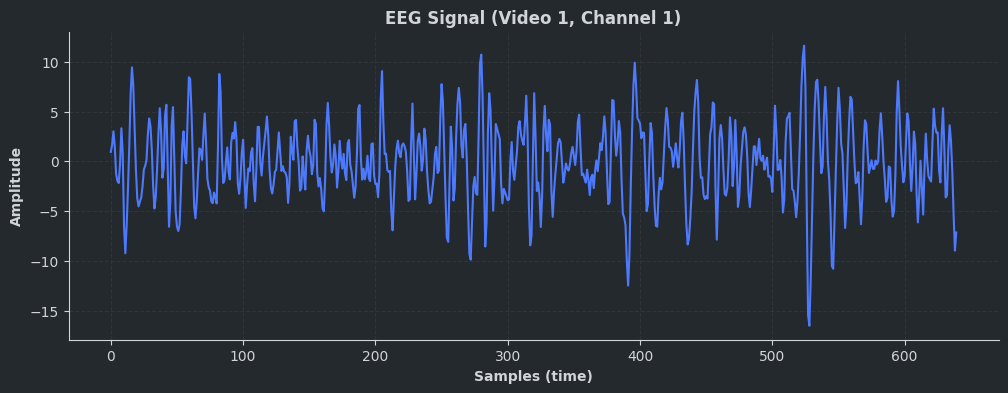

In [15]:
video_index = 0
channel_index = 0
sampling_frequency = 128
seconds = 5

sample_signal = subject_eeg_data[
    video_index, 
    channel_index, 
    0:sampling_frequency*seconds
]

background_color = '#24292e'
line_color = '#4d79fd'
text_color = '#d1d5da'
grid_color = '#313439'

plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.set_facecolor('#24292e')
plt.gcf().patch.set_facecolor(background_color)

plt.plot(sample_signal, color=line_color) 
plt.title(f'EEG Signal (Video {video_index + 1}, Channel {channel_index + 1})', color=text_color, fontweight='bold')
plt.xlabel('Samples (time)', color=text_color, fontweight='bold')
plt.ylabel('Amplitude', color=text_color, fontweight='bold')

ax.tick_params(colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(True, linestyle='--', color=grid_color)

plt.show()


The EEG signal shown above — already preprocessed in the source data to remove common artifacts such as eye blinks — reflects clean neural activity patterns suitable for further transformation into **frequency-domain features**. These features will later serve as input for a **convolutional neural network (CNN)** model in our emotion classification task.

To better understand the temporal dynamics of these frequency components, using `SciPy` library we compute a **spectrogram** of the signal recorded during the first movie presentation from the first channel. Spectrograms allow us to visualize **how the power of various frequency bands evolves over time**, which is particularly important in EEG-based emotion recognition — since distinct emotional states are often linked to specific oscillatory patterns in the brain (e.g., **Alpha (8-13 Hz)** suppression during heightened arousal, or increased **Theta (4-8 Hz)** activity during calmness or introspection).

*Note:*
*Due to the use of sliding windows with overlap in spectrogram computation* `(nperseg=128, noverlap=64)`*, the resulting time axis starts slightly after 0 seconds and ends before 5 seconds. This ensures that each time window contains a complete set of samples needed for the Fourier transform.*


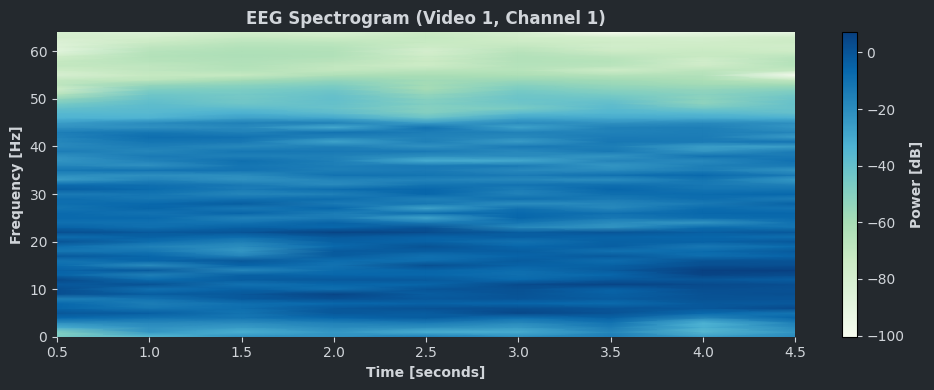

In [16]:
frequencies, times, spec_power = spectrogram(
    sample_signal, 
    fs=sampling_frequency, 
    nperseg=128, 
    noverlap=64
)

plt.figure(figsize=(10, 4))

ax = plt.gca()
ax.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

pcm = plt.pcolormesh(
    times, 
    frequencies, 
    10 * np.log10(spec_power), 
    shading='gouraud', 
    cmap='GnBu'
)

plt.title(f'EEG Spectrogram (Video {video_index + 1}, Channel {channel_index + 1})', color=text_color, fontweight='bold')
plt.xlabel('Time [seconds]', color=text_color, fontweight='bold')
plt.ylabel('Frequency [Hz]', color=text_color, fontweight='bold')

ax.tick_params(colors=text_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(False)

cbar = plt.colorbar(pcm)
cbar.ax.yaxis.set_tick_params(color=text_color)
plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)
cbar.set_label('Power [dB]', color=text_color, fontweight='bold')

plt.tight_layout()
plt.show()


# **4. EEG feature extraction and target variable generation**

## **4.1. Aggregating data from all participants**

In [17]:
data_path = 'data_preprocessed_python'
all_eeg_data = []
all_labels = []

for i in range(1, 33):
    file_name = f's{i:02}.dat'
    file_path = os.path.join(data_path, file_name)

    with open(file_path, 'rb') as f:
        subject_data = pickle.load(f, encoding='latin1')
        all_eeg_data.append(subject_data['data'])
        all_labels.append(subject_data['labels'])

eeg_data_all = np.concatenate(all_eeg_data, axis=0)
labels_all = np.concatenate(all_labels, axis=0)

print(eeg_data_all.shape)
print(labels_all.shape)


(1280, 40, 8064)
(1280, 4)


## **4.2. Generating binary arousal labels**

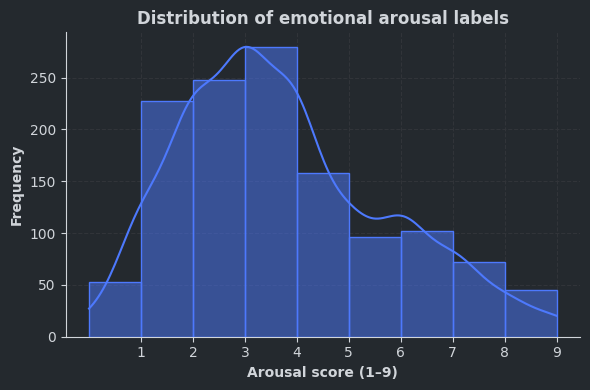

In [18]:
arousal_labels = labels_all[:, 1]

plt.figure(figsize=(6, 4))
ax = plt.gca()

ax.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

sns.histplot(arousal_labels, bins=9, kde=True, color=line_color, edgecolor=line_color, ax=ax, zorder=3)

ax.set_title('Distribution of emotional arousal labels', color=text_color, fontweight='bold')
ax.set_xlabel('Arousal score (1–9)', color=text_color, fontweight='bold')
ax.set_ylabel('Frequency', color=text_color, fontweight='bold')

ax.tick_params(colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', color=grid_color, zorder=0)

plt.xticks(range(1, 10), color=text_color)
plt.yticks(color=text_color)

plt.tight_layout()
plt.show()


In [19]:
arousal_labels = labels_all[:, 1]
median = np.median(arousal_labels)
print(f"Median score: {median}")

Median score: 3.315


In [20]:
binary_arousal = (arousal_labels > median).astype(int)

print(np.unique(binary_arousal, return_counts=True))

(array([0, 1]), array([640, 640], dtype=int64))


## **4.3. Bandpower features (theta, alpha, beta, gamma) extraction**

In [40]:
def bandpower(signal, fs, band):
    f, Pxx = welch(signal, fs=fs)
    band_mask = (f >= band[0]) & (f <= band[1])
    return np.sum(Pxx[band_mask])

bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45),
}

sampling_frequency = 128
window_size = sampling_frequency * 5
step_size = int(sampling_frequency * 2.5)

train_trials, test_trials, train_labels, test_labels = train_test_split(
    eeg_data_all, binary_arousal, test_size=0.2, stratify=binary_arousal, random_state=42
)

def extract_features(trials, labels):
    X_features = []
    y_expanded = []

    for trial, label in zip(trials, labels):
        trial_len = trial.shape[1]

        for start in range(0, trial_len - window_size + 1, step_size):
            features = []

            for ch in range(32):
                signal = trial[ch, start:start + window_size]
                signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)

                total_power = bandpower(signal, fs=sampling_frequency, band=(4, 45))
                
                for band in bands.values():
                    bp = bandpower(signal, fs=sampling_frequency, band=band)
                    rel_bp = bp / (total_power + 1e-10)
                    
                    features.append(bp)
                    features.append(rel_bp) 

            X_features.append(features)
            y_expanded.append(label)

    return np.array(X_features), np.array(y_expanded)

X_train, y_train = extract_features(train_trials, train_labels)
X_test, y_test = extract_features(test_trials, test_labels)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (24576, 256)
y_train shape: (24576,)
X_test shape: (6144, 256)
y_test shape: (6144,)


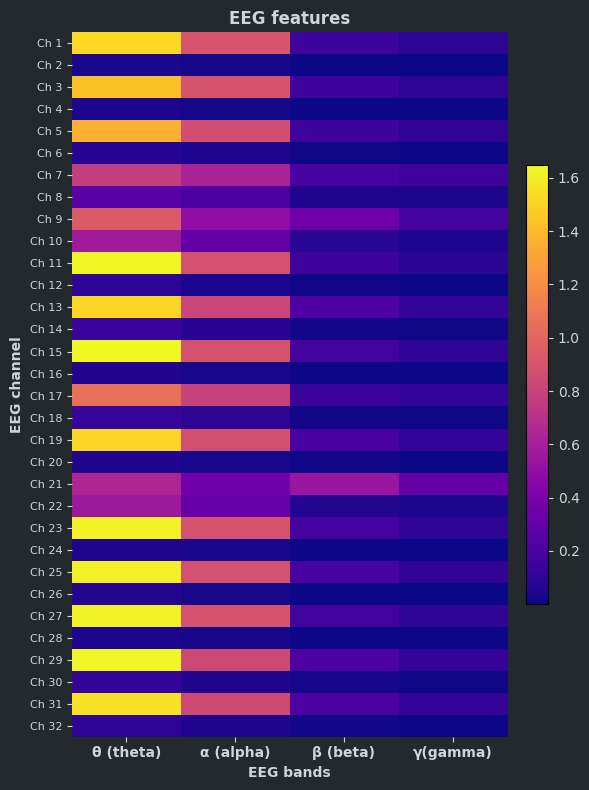

In [41]:
example = X_train[0][:128].reshape(32, 4)

fig, ax = plt.subplots(figsize=(6, 8))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

im = ax.imshow(example, aspect='auto', cmap='plasma')

ax.set_title("EEG features", color=text_color, fontweight='bold')
ax.set_xlabel("EEG bands", color=text_color, fontweight='bold')
ax.set_ylabel("EEG channel", color=text_color, fontweight='bold')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['θ (theta)', 'α (alpha)', 'β (beta)', 'γ(gamma)'], color=text_color, fontweight='bold')
ax.set_yticks(np.arange(32))
ax.set_yticklabels([f'Ch {i+1}' for i in range(32)], color=text_color, fontsize=8)

ax.tick_params(colors=text_color)
for spine in ax.spines.values():
    spine.set_visible(False)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(color=text_color)
plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)

plt.tight_layout()
plt.show()


## **4.4. Feature selection using random forest importance**

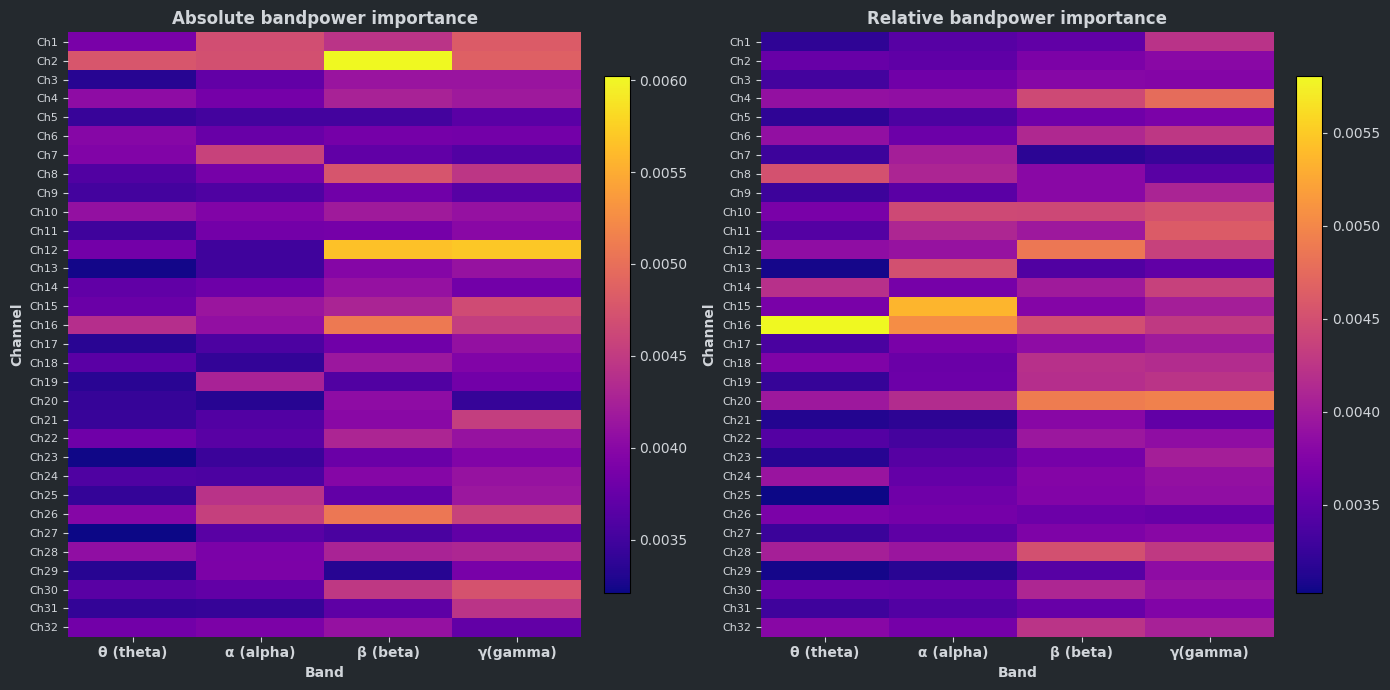

In [273]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importance = rf.feature_importances_

abs_bandpower = rf_importance[:128].reshape(32, 4)
rel_bandpower = rf_importance[128:].reshape(32, 4)

bands = ['θ (theta)', 'α (alpha)', 'β (beta)', 'γ(gamma)']
channels = [f'Ch{i+1}' for i in range(32)]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.patch.set_facecolor(background_color)

for ax, data, title, cmap in zip(
    axes,
    [abs_bandpower, rel_bandpower],
    ["Absolute bandpower importance", "Relative bandpower importance"],
    ['plasma', 'plasma']
):
    ax.set_facecolor(background_color)

    im = ax.imshow(data, aspect='auto', cmap=cmap)
    ax.set_title(title, color=text_color, fontweight='bold')
    ax.set_xlabel("Band", color=text_color, fontweight='bold')
    ax.set_ylabel("Channel", color=text_color, fontweight='bold')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(bands, color=text_color, fontweight='bold')
    ax.set_yticks(np.arange(32))
    ax.set_yticklabels(channels, color=text_color, fontsize=8)
    ax.tick_params(colors=text_color)

    for spine in ax.spines.values():
        spine.set_visible(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.set_tick_params(color=text_color)
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)

plt.tight_layout()
plt.show()


In [274]:
df_stats = pd.DataFrame({
    'feature_index': range(X_train.shape[1]),
    'rf_importance': rf_importance
})

df_sorted_by_rf = df_stats.sort_values('rf_importance', ascending=False)


In [275]:
k = 50
top_k_features = df_sorted_by_rf['feature_index'].head(k).values

X_train_top = X_train.iloc[:, top_k_features]
X_test_df = pd.DataFrame(X_test)
X_test_top = X_test_df.iloc[:, top_k_features]


## **4.5. Feature scaling**

In [276]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_test_scaled = scaler.transform(X_test_top)


# **5. Neural network model**

## **5.1. Model architecture**

In [263]:
model = Sequential([
    Input(shape=(50,)),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)


## **5.2. Training**

In [264]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5234 - loss: 1.1606 - val_accuracy: 0.5767 - val_loss: 0.9429
Epoch 2/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5736 - loss: 0.9193 - val_accuracy: 0.5947 - val_loss: 0.8300
Epoch 3/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6000 - loss: 0.8022 - val_accuracy: 0.5869 - val_loss: 0.7587
Epoch 4/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6027 - loss: 0.7376 - val_accuracy: 0.5778 - val_loss: 0.7261
Epoch 5/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6078 - loss: 0.7052 - val_accuracy: 0.6001 - val_loss: 0.7000
Epoch 6/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6057 - loss: 0.6930 - val_accuracy: 0.5687 - val_loss: 0.6999
Epoch 7/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6129 - loss: 0.6818 - val_accuracy: 0.5791 - val_loss: 0.6966
Epoch 8/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6088 - loss: 0.6819 - val_accuracy: 0.

## **5.3. Evaluation**

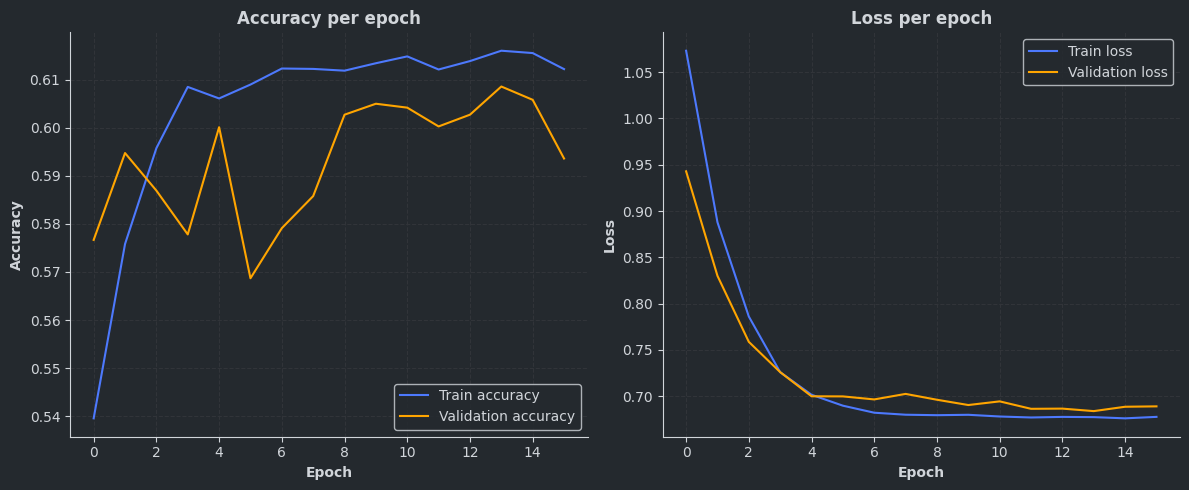

In [265]:
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

ax1.plot(history.history['accuracy'], label='Train accuracy', color=line_color)
ax1.plot(history.history['val_accuracy'], label='Validation accuracy', color='orange')
ax1.set_title('Accuracy per epoch', color=text_color, fontweight='bold')
ax1.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax1.set_ylabel('Accuracy', color=text_color, fontweight='bold')
ax1.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax1.tick_params(colors=text_color)
ax1.spines['bottom'].set_color(text_color)
ax1.spines['left'].set_color(text_color)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, linestyle='--', color=grid_color)

ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor(background_color)

ax2.plot(history.history['loss'], label='Train loss', color=line_color)
ax2.plot(history.history['val_loss'], label='Validation loss', color='orange')
ax2.set_title('Loss per epoch', color=text_color, fontweight='bold')
ax2.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax2.set_ylabel('Loss', color=text_color, fontweight='bold')
ax2.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax2.tick_params(colors=text_color)
ax2.spines['bottom'].set_color(text_color)
ax2.spines['left'].set_color(text_color)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='--', color=grid_color)

plt.tight_layout()
plt.show()


In [266]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.61
ROC AUC: 0.64


# **6. Classical machine learning models**

## **6.1. Logistic regression**

In [268]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      3072
           1       0.59      0.59      0.59      3072

    accuracy                           0.59      6144
   macro avg       0.59      0.59      0.59      6144
weighted avg       0.59      0.59      0.59      6144

ROC AUC: 0.64


## **6.2. Random forest**

In [277]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

print("Random forest:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


Random forest:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      3072
           1       0.61      0.59      0.60      3072

    accuracy                           0.61      6144
   macro avg       0.61      0.61      0.61      6144
weighted avg       0.61      0.61      0.61      6144

ROC AUC: 0.64


## **6.3. Support vector machine**

In [279]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
y_prob = svm.predict_proba(X_test_scaled)[:, 1]

print("SVM:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


SVM:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      3072
           1       0.62      0.69      0.65      3072

    accuracy                           0.63      6144
   macro avg       0.63      0.63      0.63      6144
weighted avg       0.63      0.63      0.63      6144

ROC AUC: 0.64


## **6.4. XGBoost**

In [278]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

y_pred = xgb.predict(X_test_scaled)
y_prob = xgb.predict_proba(X_test_scaled)[:, 1]

print("XGBoost:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


c:\Users\Huawei\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:21:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost:
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      3072
           1       0.60      0.59      0.59      3072

    accuracy                           0.60      6144
   macro avg       0.60      0.60      0.60      6144
weighted avg       0.60      0.60      0.60      6144

ROC AUC: 0.64


# **7. Summary and conclusions**

In [280]:
results = pd.DataFrame({
    'Model': ['Neural network', 'Logistic regression', 'Random forest', 'SVM', 'XGBoost'],
    'Accuracy': [0.61, 0.59, 0.61, 0.63, 0.60],
    'ROC AUC': [0.64, 0.64, 0.64, 0.64, 0.64]
})

results

,Model,Accuracy,ROC AUC
0,Neural network,0.61,0.64
1,Logistic regression,0.59,0.64
2,Random forest,0.61,0.64
3,SVM,0.63,0.64
4,XGBoost,0.60,0.64


### **Author of the notebook**

Michał Owsiak